In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale , StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV , cross_val_score
from sklearn.metrics import confusion_matrix ,accuracy_score, mean_squared_error,r2_score,roc_auc_score,classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
import warnings
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
warnings.simplefilter(action="ignore")

In [3]:
df=pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.Outcome.unique()

array([1, 0])

In [6]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [7]:
df["Outcome"].value_counts()*100/len(df)

0    65.104167
1    34.895833
Name: Outcome, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e17bec390>,
      dtype=object)

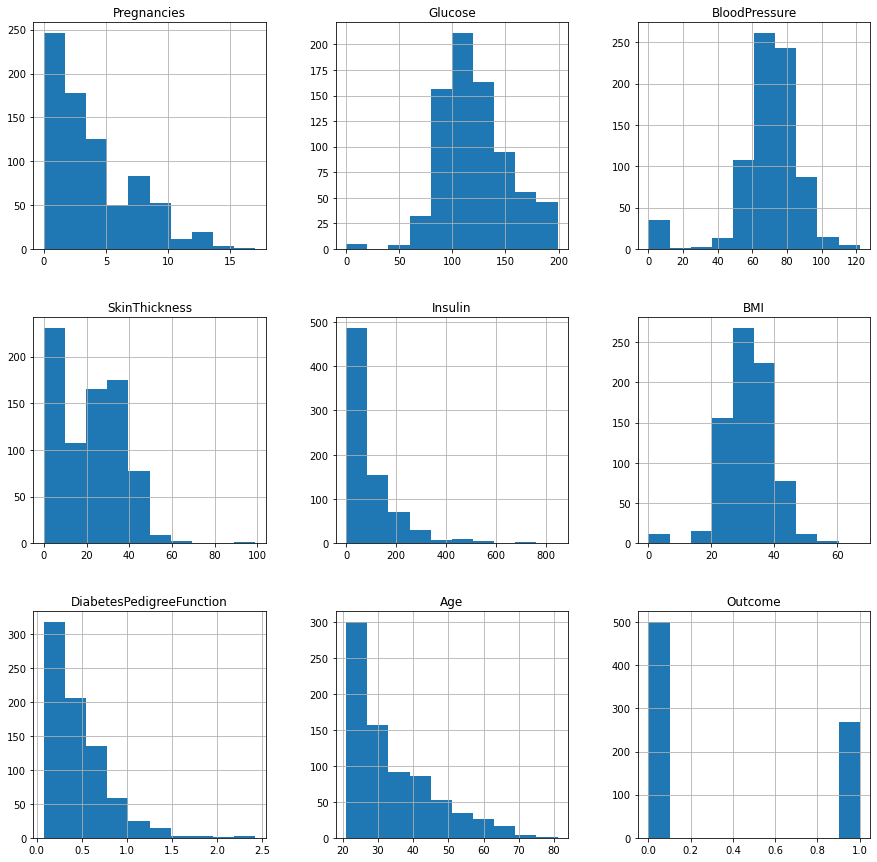

In [8]:
df.hist(figsize = (15,15))

In [9]:
df.loc[(df.Age < 25)& (df.Outcome ==1)].Outcome.count()

31

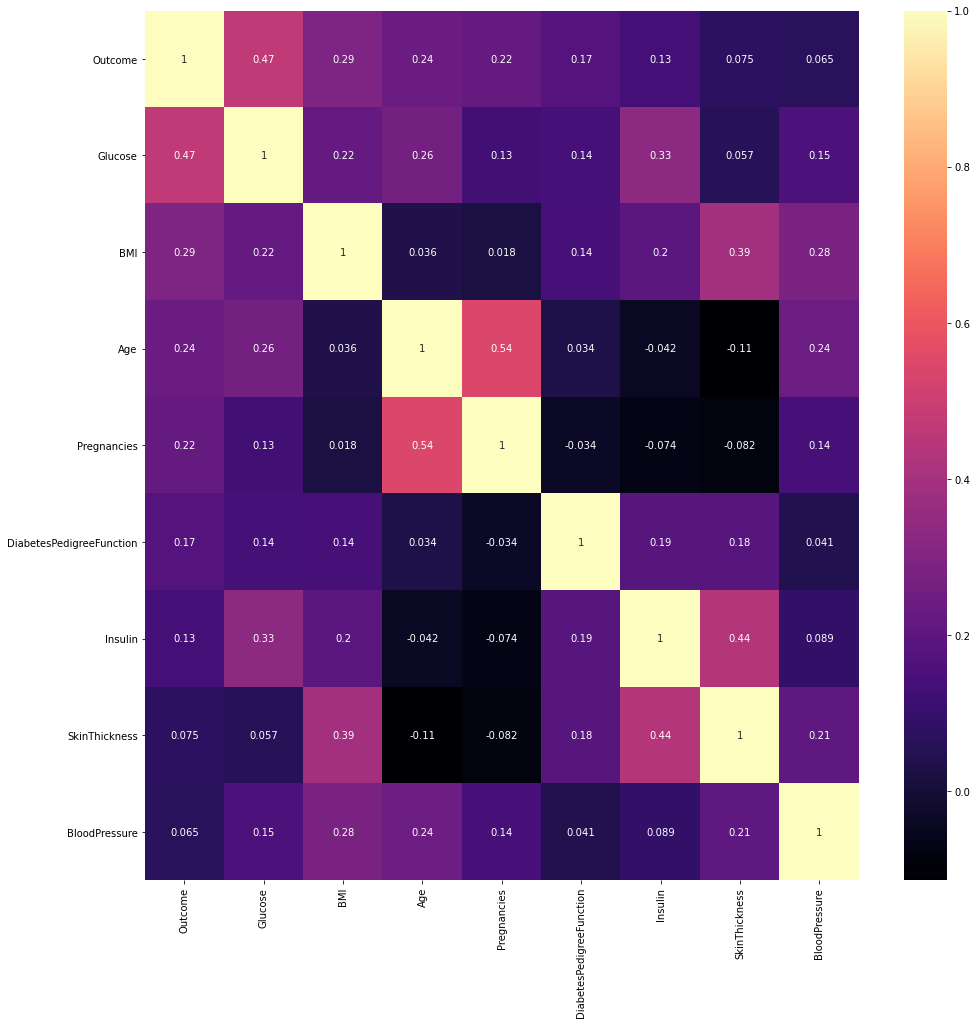

In [10]:
#corolation matrix
k=9
cols=df.corr().nlargest(k,'Outcome')['Outcome'].index
cm=df[cols].corr()
plt.figure(figsize=(16,16))
sns.heatmap(cm,annot=True,cmap='magma')

In [12]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [14]:
df.groupby("Outcome").agg({"Pregnancies":"mean","Age":"mean","Insulin":"mean","Glucose":"mean"})

,Pregnancies,Age,Insulin,Glucose
Outcome,,,,
0,3.298000,31.190000,68.792000,109.980000
1,4.865672,37.067164,100.335821,141.257463


In [15]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [16]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [17]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [18]:
def median_target(var):
    temp=df[df[var].notnull()]
    temp=temp[[var,'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

columns=df.columns
columns=columns.drop("Outcome")
for i in columns:
    median_target(i)
    df.loc[(df['Outcome']==0)&(df[i].isnull()),i]=median_target(i)[i][0]
    df.loc[(df['Outcome']==1)&(df[i].isnull()),i]=median_target(i)[i][1]

In [19]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [27]:
median_target('Glucose')['Glucose'][0]

107.0

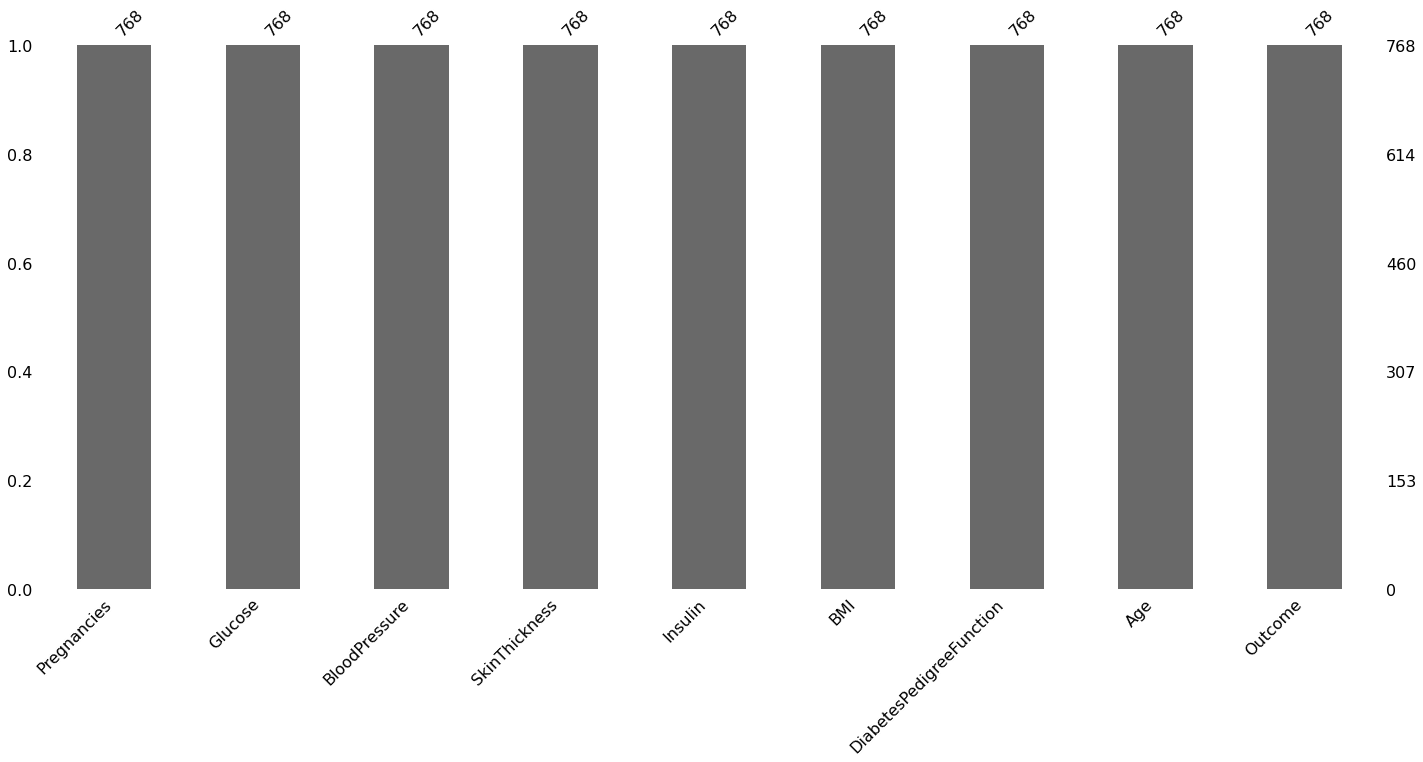

In [28]:
import missingno as msno
msno.bar(df);

In [29]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [30]:
def has_outliers(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    if dataframe[(dataframe[variable] < low_limit) | (dataframe[variable] > up_limit)].any(axis=None):
        print(variable, "yes")
    else: 
        print(variable, "no")

In [31]:
def replace_with_thresholds(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [32]:
for col in df.columns: 
    has_outliers(df,col)

Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


In [33]:
replace_with_thresholds(df, df.columns)

In [34]:
for col in df.columns: 
    has_outliers(df,col)

Pregnancies no
Glucose no
BloodPressure no
SkinThickness no
Insulin no
BMI no
DiabetesPedigreeFunction no
Age no
Outcome no


In [35]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1.0


**Feature Engeneering**

In [41]:
NewBMI=pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")
df["NewBMI"] = NewBMI


In [42]:
df.loc[df["BMI"]<18.5,"NewBMI"]=NewBMI[0]
df.loc[(df["BMI"] > 18.5) & (df["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
df.loc[(df["BMI"] > 24.9) & (df["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
df.loc[(df["BMI"] > 29.9) & (df["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
df.loc[(df["BMI"] > 34.9) & (df["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
df.loc[df["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]

In [43]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1.0,Obesity 1
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0.0,Overweight
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1.0,Normal
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0,Overweight
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1.0,Obesity 3


In [52]:
df.loc[(df.Outcome == 0) & (df.Insulin >= 200 ) , "Insulin"]

20     235.0
54     270.0
73     270.0
95     228.0
139    270.0
144    270.0
150    204.0
153    270.0
162    270.0
228    270.0
247    270.0
248    270.0
258    270.0
279    270.0
286    270.0
297    215.0
320    231.0
335    255.0
364    270.0
392    270.0
395    270.0
412    270.0
452    210.0
486    270.0
487    265.0
511    210.0
519    270.0
538    210.0
555    215.0
574    270.0
594    230.0
608    270.0
645    270.0
657    200.0
673    240.0
679    265.0
685    205.0
700    200.0
707    270.0
710    270.0
713    270.0
721    200.0
Name: Insulin, dtype: float64

In [55]:
df.loc[(df.Outcome == 1) & (df.Insulin <= 100) , "Insulin"] = 70
df.loc[(df.Outcome == 0) & (df.Insulin >= 200 ) , "Insulin"] = 200
df.loc[(df.Outcome == 0) & (df.Glucose >= 175 ) , "Glucose"] = 175
df.loc[(df.Outcome == 1) & (df.Glucose <= 80 ) , "Glucose"] = 80
df.loc[(df.Outcome == 0) & (df.Pregnancies >= 13 ) , "Pregnancies"] = 13
df.loc[(df.Outcome == 0) & (df.DiabetesPedigreeFunction >= 1.3 ) , "DiabetesPedigreeFunction"] = 1.3
df.loc[(df.Outcome == 0) & (df.BMI >= 50 ) , "BMI"] = 50
df["NEW_g_p"] = (df.Glucose * df.Pregnancies) 
df["NEW_i_g"] = (df.Glucose * df.Insulin)

In [56]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NEW_g_p,NEW_i_g
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1.0,Obesity 1,888.0,25086.0
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0.0,Overweight,85.0,8712.5
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1.0,Normal,1464.0,31018.5
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0,Overweight,89.0,8366.0
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1.0,Obesity 3,0.0,23016.0


In [57]:
df['New_Glucose'] = pd.cut(x=df['Glucose'], bins=[0,74,99,139,200],labels = ["Low","Normal","Overweight","High"])

In [59]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NEW_g_p,NEW_i_g,New_Glucose
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1.0,Obesity 1,888.0,25086.0,High
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0.0,Overweight,85.0,8712.5,Normal
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1.0,Normal,1464.0,31018.5,High
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0,Overweight,89.0,8366.0,Normal
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1.0,Obesity 3,0.0,23016.0,Overweight
5,5.0,116.0,74.0,27.0,102.5,25.6,0.201,30.0,0.0,Overweight,580.0,11890.0,Overweight
6,3.0,80.0,50.0,32.0,70.0,31.0,0.248,26.0,1.0,Obesity 1,240.0,5600.0,Normal
7,10.0,115.0,70.0,27.0,102.5,35.3,0.134,29.0,0.0,Obesity 2,1150.0,11787.5,Overweight
8,2.0,197.0,70.0,42.5,270.0,30.5,0.158,53.0,1.0,Obesity 1,394.0,53190.0,High
9,8.0,125.0,96.0,32.0,169.5,34.3,0.232,54.0,1.0,Obesity 1,1000.0,21187.5,Overweight


In [60]:
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"

In [61]:
df = df.assign(NewInsulinScore=df.apply(set_insulin, axis=1))

In [63]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NEW_g_p,NEW_i_g,New_Glucose,NewInsulinScore
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1.0,Obesity 1,888.0,25086.0,High,Abnormal
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0.0,Overweight,85.0,8712.5,Normal,Normal
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1.0,Normal,1464.0,31018.5,High,Abnormal
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0,Overweight,89.0,8366.0,Normal,Normal
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1.0,Obesity 3,0.0,23016.0,Overweight,Abnormal


In [64]:
df.shape[1]

14

In [67]:
k = list(df.columns)
df= pd.get_dummies(df, columns=[categorical_columns],
                               dummy_na=False, drop_first=True)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'NewBMI',
       'NEW_g_p', 'NEW_i_g', 'New_Glucose', 'NewInsulinScore'],
      dtype='object')

In [68]:
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,
                               dummy_na=nan_as_category, drop_first=True)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns


In [71]:
categorical_columns=[c for c in df.columns[(df.dtypes=='object')|(df.dtypes=='category')]]
categorical_columns

['NewBMI', 'New_Glucose', 'NewInsulinScore']

In [74]:
df, new_cols_ohe = one_hot_encoder(df,categorical_columns)
new_cols_ohe

['NewBMI_Obesity 1',
 'NewBMI_Obesity 2',
 'NewBMI_Obesity 3',
 'NewBMI_Overweight',
 'NewBMI_Underweight',
 'New_Glucose_Normal',
 'New_Glucose_Overweight',
 'New_Glucose_High',
 'NewInsulinScore_Normal']

In [75]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_g_p,NEW_i_g,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,New_Glucose_Normal,New_Glucose_Overweight,New_Glucose_High,NewInsulinScore_Normal
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1.0,888.0,25086.0,1,0,0,0,0,0,0,1,0
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0.0,85.0,8712.5,0,0,0,1,0,1,0,0,1
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1.0,1464.0,31018.5,0,0,0,0,0,0,0,1,0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0,89.0,8366.0,0,0,0,1,0,1,0,0,1
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1.0,0.0,23016.0,0,0,1,0,0,0,1,0,0


In [76]:
df.shape[1]

20

In [77]:
y = df["Outcome"]
X = df.drop(["Outcome",'NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','New_Glucose_Normal', 'New_Glucose_Overweight', 'New_Glucose_High'], axis = 1)
cols = X.columns
index = X.index

In [81]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NEW_g_p,NEW_i_g
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,888.0,25086.0
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,85.0,8712.5
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1464.0,31018.5
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,89.0,8366.0
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,0.0,23016.0


In [82]:
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

In [83]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NEW_g_p,NEW_i_g
0,0.6,0.765432,0.000,1.000000,1.000000,0.170330,0.665359,1.235294,0.914929,0.866965
1,-0.4,-0.790123,-0.375,0.142857,0.000000,-0.598901,-0.056209,0.117647,-0.424520,-0.418138
2,1.0,1.629630,-0.500,0.571429,1.000000,-0.961538,0.783007,0.176471,1.875730,1.332588
3,-0.4,-0.691358,-0.375,-0.714286,-0.126866,-0.434066,-0.537255,-0.470588,-0.417848,-0.445334
4,-0.6,0.493827,-2.000,1.000000,0.977612,1.214286,2.163399,0.235294,-0.566305,0.704497


In [85]:
categorical_df = df[['NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','New_Glucose_Normal', 'New_Glucose_Overweight', 'New_Glucose_High']]
X = pd.concat([X,categorical_df], axis = 1)

In [86]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NEW_g_p,NEW_i_g,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,New_Glucose_Normal,New_Glucose_Overweight,New_Glucose_High
0,0.6,0.765432,0.000,1.000000,1.000000,0.170330,0.665359,1.235294,0.914929,0.866965,1,0,0,0,0,0,0,0,1
1,-0.4,-0.790123,-0.375,0.142857,0.000000,-0.598901,-0.056209,0.117647,-0.424520,-0.418138,0,0,0,1,0,1,1,0,0
2,1.0,1.629630,-0.500,0.571429,1.000000,-0.961538,0.783007,0.176471,1.875730,1.332588,0,0,0,0,0,0,0,0,1
3,-0.4,-0.691358,-0.375,-0.714286,-0.126866,-0.434066,-0.537255,-0.470588,-0.417848,-0.445334,0,0,0,1,0,1,1,0,0
4,-0.6,0.493827,-2.000,1.000000,0.977612,1.214286,2.163399,0.235294,-0.566305,0.704497,0,0,1,0,0,0,0,1,0


**Modeling**

In [87]:
X = df.drop("Outcome",axis=1)
y = df["Outcome"]

In [89]:
models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ('SVR', SVC(gamma='auto')),
          ('XGBM', XGBClassifier()),
          ('GBM',GradientBoostingClassifier()),
          ("LightGBM", LGBMClassifier())]
# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=123456)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.824180 (0.028939)
KNN: 0.805930 (0.032436)
CART: 0.904990 (0.030154)
RF: 0.906288 (0.040088)
SVR: 0.651025 (0.072141)
XGBM: 0.928435 (0.029232)
GBM: 0.934894 (0.026131)
LightGBM: 0.929699 (0.033494)


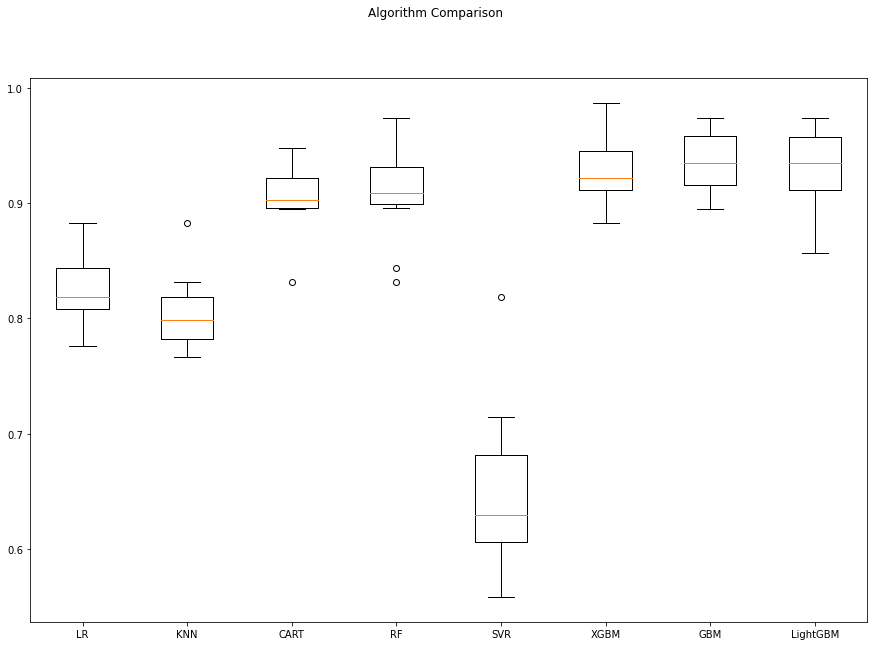

In [90]:
#boxplot for comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [91]:
gbm_model = GradientBoostingClassifier()
# Model Tuning
gbm_params = {"learning_rate": [0.01, 0.1, 0.001],
               "max_depth": [3,5, 8, 10],
               "n_estimators": [200, 500, 1000],
               "subsample": [1, 0.5, 0.8]}
gbm_cv_model = GridSearchCV(gbm_model,
                            gbm_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=2).fit(X, y)
gbm_cv_model.best_params_
# Final Model Installation
gbm_tuned = GradientBoostingClassifier(**gbm_cv_model.best_params_).fit(X,y)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 17.8min finished


In [92]:
cross_val_score(gbm_tuned, X, y, cv = 10).mean()

0.9323308270676692

In [93]:
lgb_model = LGBMClassifier()
# Model Tuning
lgbm_params = lgbm_params = {"learning_rate": [0.01, 0.5, 1],
                             "n_estimators": [200, 500, 1000],
                             "max_depth": [6, 8, 10],
                             "colsample_bytree": [1, 0.5, 0.4 ,0.3 , 0.2]}
lgbm_cv_model = GridSearchCV(lgb_model,
                             lgbm_params,
                             cv=10,
                             n_jobs=-1,
                             verbose=2).fit(X, y)
lgbm_cv_model.best_params_
# Final Model Installation
lgbm_tuned = LGBMClassifier(**lgbm_cv_model.best_params_).fit(X, y)

Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1343 out of 1350 | elapsed:  1.6min remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  1.6min finished


In [94]:
cross_val_score(lgbm_tuned, X, y, cv = 10).mean()

0.9349453178400546

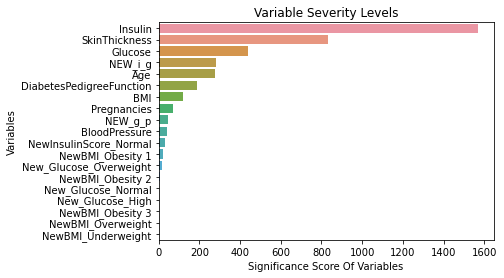

In [95]:
feature_imp = pd.Series(lgbm_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

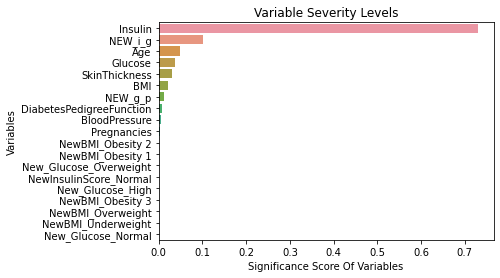

In [96]:
feature_imp = pd.Series(gbm_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

In [97]:
models = []
models.append(('RF', RandomForestClassifier(random_state = 12345, max_depth = 8, max_features = 7, min_samples_split = 2, n_estimators = 500)))
models.append(('GBM', GradientBoostingClassifier(random_state = 12345, learning_rate = 0.1, max_depth = 5, min_samples_split = 0.1, n_estimators = 100, subsample = 1.0)))
models.append(("LightGBM", LGBMClassifier(random_state = 12345, learning_rate = 0.01,  max_depth = 3, n_estimators = 1000)))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    
        kfold = KFold(n_splits = 10, random_state = 12345)
        cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

RF: 0.921890 (0.016364)
GBM: 0.931015 (0.020090)
LightGBM: 0.921873 (0.023312)


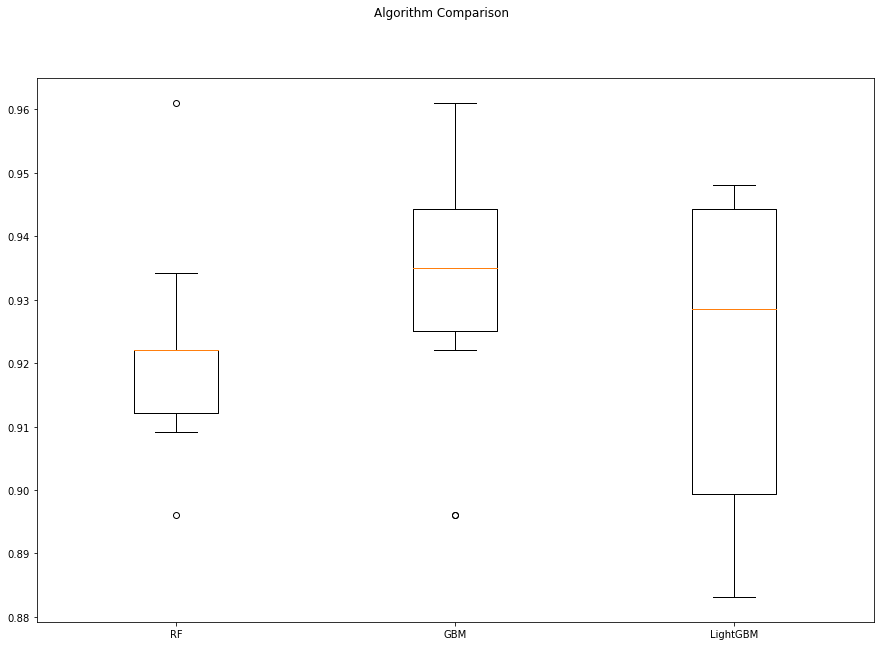

In [98]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**GBM hs the best result 0.93**